## Remarques

J'ai changé mon backend pour PyTorch car PyTorch dispose de plus de fonctions pré-implémentées qui s'occuppent du calcul de gradient dans la backpropagation que Paddle et parce qu'on a utilisé PyTorch dans le cours de Deep Learning.

Avec les modifications faites, changer l'emplacement de la source à un impact sur le résultat lorsque le terme de source est différent de $0$. Cependant il y a toujours ce problème de valeurs bizarres en $(x,y) = (0, 0)$

J'ai rempacé le Dirac par une gaussienne pour représenter la source car GPT m'a expliqué qu'utiliser des fonctions non régulières peut poser des problèmes numériques pour l'entraînement.

Il y a peut etre trop peut de points d'entrainement: si on voulait qu'il y ait un point d'entrainement tous les 1 m et toutes les 0.1 s il faudrait
500 * 500 * 100 = 25 000 000 points d'entrainement ! J'ai l'impression en regardant les résultats que le modèle arrive à apprendre la diffusion. Je pense que le problème majeur est que le modèle n'arrive pas à apprendre la condition initiale, ce qui cause les problèmes au point $(0, 0)$ et ces problèmes se propagent ensuite lorsque $t$ augmente.

Est-ce que le probleme est bien posé ? Est-ce qu'une condition initiale suffit ?
Modif: En fait ChatGPT m'a dit que pour des equations d'advection diffusion il faut quand meme imposer des conditions aux limites afin d'avoir une unique solution meme si le bord du domaine ne correspond a rien en particulier. J'ai donc rajouté une condition aux limite de Dirichlet qui fait en sorte que C vaille 0 au bord. Cela pourrait bien representer le phenomene physique etudie si on choisit $D$ et $u$ assez faibles pour que sur la periode de temps etudiée le polluant n'ait pas le temps de sortir du domaine etudié.

In [1]:
!pip install deepxde

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.8/179.8 kB 1.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.3/100.3 kB 1.6 MB/s eta 0:00:00


In [ ]:
# On choisit le backend souahite
import os

os.environ['DDE_BACKEND'] = 'pytorch'

import deepxde as dde

Using backend: pytorch
Other supported backends: tensorflow.compat.v1, tensorflow, jax, paddle.
paddle supports more examples now and is recommended.


In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
import matplotlib.colors

In [ ]:
# Fait en sorte que tous les tenseurs soient crees sur le GPU (s'il est accessible)
if torch.cuda.is_available():
  torch.cuda.set_device(0)

In [ ]:
# Definition des parametres
Lx = 500 # largeur du domaine
Ly = 500 # longueur du domaine
u = np.array([0, 0])  # (ux, uy)
D = 50**2 / 10  # coeff de diffusion
T = 10  # temps final
coords_S = torch.tensor([Lx / 4, Ly / 4])  # coordonnees de la source
S = 0  # valeur de la source

In [ ]:
# Definition des domaines de temps et d'espace
geom = dde.geometry.geometry_2d.Rectangle([-Lx / 2, -Ly / 2], [Lx / 2, Ly / 2])
timedomain = dde.geometry.TimeDomain(0, T)
geomtime = dde.geometry.GeometryXTime(geom, timedomain)


def normal_pdf(z, mu):
    """densite d'une gaussienne reduite (Cov = Id) non normalisee
    z est un array 2d ou chaque ligne correspond a une position spatiale (x,y)"""
    res = torch.sum(torch.square(z - mu), dim=-1) # norme 2 au carre
    res = torch.exp(- res / 2)
    return res.view((-1, 1))


def pde(p, C):
    """residu de l'equadif
    p contient les coordonnes spatiales x, y et le temps t
    ainsi si on s'interesse au point i de coordonnees (xi, yi, ti)
    il est stocke dans p a la ieme ligne et on a donc
    p[i, 0] = xi; p[i, 1] = yi; p[i, 2] = ti
    C correspond a C(p) la concentration en p"""

    dC_x = dde.grad.jacobian(C, p, j=0)
    dC_y = dde.grad.jacobian(C, p, j=1)
    dC_t = dde.grad.jacobian(C, p, j=2)

    dC_xx = dde.grad.hessian(C, p, i=0, j=0)
    dC_yy = dde.grad.hessian(C, p, i=1, j=1)

    return (
        dC_t
        + u[0] * dC_x
        + u[1] * dC_y
        - D * (dC_xx + dC_yy)
        - normal_pdf(p[:, 0:2], coords_S) * S
    )


# Definition des conditions aux limites
coords_S_np = coords_S.cpu().numpy()
nb_source_points = 20
times = np.linspace(0, T, nb_source_points)
source_points = np.tile(coords_S_np, (nb_source_points, 1))
source_points_time = np.c_[ source_points, times]


def initial_condition(p):
    p_tensor = torch.tensor(p)
    return normal_pdf(p_tensor[:, 0:2], coords_S) * S


ic = dde.icbc.IC(geomtime, initial_condition, lambda _, on_initial: on_initial)

bc = dde.icbc.DirichletBC(geomtime, lambda x: 0, lambda _, on_boundary: on_boundary)


# On concatene tout dans data
data = dde.data.TimePDE(
    geomtime,
    pde,
    [ic, bc],
    num_domain = 50 * 50 * 20,
    num_boundary = 2 * 50 * 20,
    num_initial = 500 * 500,
    anchors=source_points_time,
)


# Definition de l'architecture du reseau de neurones
net = dde.nn.FNN([3] + [20] * 3 + [1], "tanh", "Glorot normal")
model = dde.Model(data, net)

In [ ]:
# Entrainement de reseau de neurones
model.compile("adam", lr=1e-3)
losshistory, train_state = model.train(iterations=5000)
# model.compile("L-BFGS")
# losshistory, train_state = model.train()
# dde.saveplot(losshistory, train_state, issave=True, isplot=True)

Compiling model...
'compile' took 0.001111 s

Training model...

0         [1.97e+01, 7.41e-01, 7.47e-01]    [1.97e+01, 7.41e-01, 7.47e-01]    []  
1000      [4.26e-03, 4.66e-05, 5.47e-05]    [4.26e-03, 4.66e-05, 5.47e-05]    []  
2000      [1.17e-03, 1.29e-05, 1.38e-05]    [1.17e-03, 1.29e-05, 1.38e-05]    []  
3000      [5.71e-04, 4.77e-06, 5.10e-06]    [5.71e-04, 4.77e-06, 5.10e-06]    []  
4000      [3.31e-04, 2.42e-06, 2.44e-06]    [3.31e-04, 2.42e-06, 2.44e-06]    []  
5000      [1.90e-04, 1.40e-06, 1.35e-06]    [1.90e-04, 1.40e-06, 1.35e-06]    []  

Best model at step 5000:
  train loss: 1.92e-04
  test loss: 1.92e-04
  test metric: []

'train' took 545.009315 s



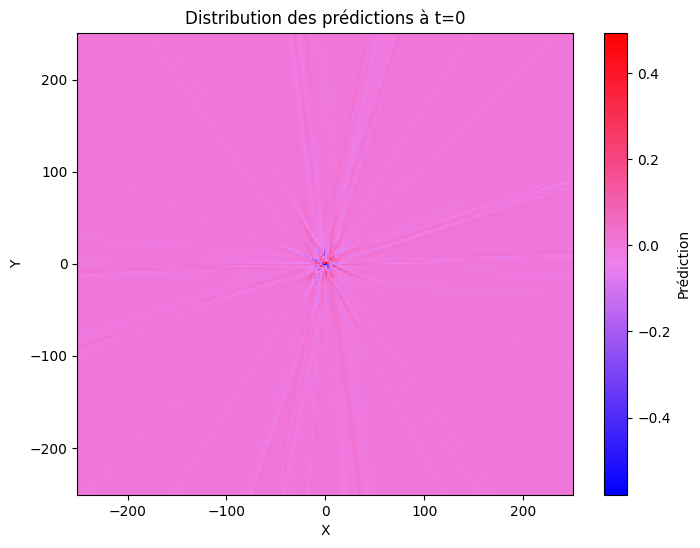

In [ ]:
# Test: on affiche le resultat au temps t
t = 0
x = geom.uniform_points(250 * 250, True)
p = np.c_[x, np.array([t] * x.shape[0])]
y = model.predict(p, operator=pde)

cmap = matplotlib.colors.LinearSegmentedColormap.from_list(
    "", ["blue", "violet", "red"]
)

resolution_mesh = 300
xi = np.linspace(-Lx / 2, Lx / 2, resolution_mesh)
yi = np.linspace(-Ly / 2, Ly / 2, resolution_mesh)
xi, yi = np.meshgrid(xi, yi)

zi = griddata((x[:, 0], x[:, 1]), y[:, 0], (xi, yi), method="linear")

plt.figure(figsize=(8, 6))
plt.pcolormesh(xi, yi, zi, cmap=cmap, shading="auto")
plt.colorbar(label="Prédiction")
plt.xlabel("X")
plt.ylabel("Y")
plt.title("Distribution des prédictions à t={}".format(t))
plt.show()